# Binary Classification with Different Features ( multiple number)

**Name**: ZHU GUANGYU  
**Student ID**: 20165953  
**Github Repo**: [assignment10](https://github.com/z1ggy-o/cv_assignment/tree/master/assignment10)  

---

In a *classification problem*, the outcome  takes on only a finit number of values. In the simplest case, outcome has only two values, for example TRUE or FALSE. This is called the *binary classification problem*.

As in real-valued data fitting, we assume that an approxomate relation ship of the form $y \approx f(x)$ holds, where $f: R^{n} \rightarrow {-1, +1}$. The model $\hat{f}$ is called a *classifier*.

For a given data point x, y with predicted outcome $\hat{y} = \hat{f}(x)$, there are four possibilities:

- *True positive*: $y = +1$ and $\hat{y} = +1$.
- *True negative*: $y = -1$ and $\hat{y} = -1$.
- *False positive*: $y = -1$ and $\hat{y} = +1$.
- *False negative*: $y = +1$ and $\hat{y} = -1$.

---

Continue ｗith assignmen09, this time we use *least squares classifer* to build classifiers for each number in MNIST data set. 

We still use feature functions $f_{i} = r_{i}^{T}x, r_{i} \sim N(0, \sigma)$, and try with varing the number of parameter $p$ with the standard deviation $\sigma = 1$ of the random feature vectore $r$.

Since this time we want to do the classification for ten numbers, our sign function is change to:
$$ argmax_{n} \tilde{f}_{n}(x)$$



---


## Create Classifier

### Import data set

We have two data sets, one for training, one for testing. Each element is a image that has height 28 and width 28 pixels.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

file_data_train = "mnist_train.csv"
file_data_test  = "mnist_test.csv"

h_data_train    = open(file_data_train, "r")
h_data_test     = open(file_data_test, "r")

data_train      = h_data_train.readlines()
data_test       = h_data_test.readlines()

h_data_train.close()
h_data_test.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_train   = len(data_train)   # number of training images
num_test    = len(data_test)    # number of testing images

# number of training images: 60000
# number of testing images: 10000

To reduce the bias, we need to normalize the data.

In [2]:
#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

Normalize each pixel, and put image data into a $784*num\_image$ matrix.

In [3]:
#
# make a matrix each column of which represents an images in a vector form 
#
list_image_train    = np.empty((size_row * size_col, num_train), dtype=float)  # 784 * num_trian matrix
list_label_train    = np.empty(num_train, dtype=int)

list_image_test     = np.empty((size_row * size_col, num_test), dtype=float)
list_label_test     = np.empty(num_test, dtype=int)

count = 0

for line in data_train:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])  # convert to float type
    im_vector   = normalize(im_vector)

    list_label_train[count]     = label
    list_image_train[:, count]  = im_vector  # each column is a image

    count += 1

count = 0

for line in data_test:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label_test[count]      = label
    list_image_test[:, count]   = im_vector    

    count += 1

### Define feature functions generator

Depends on the given number of parameters we should generate correponde feature functions $r$. Each element of $r$ is a vector with length $28 * 28$. The element of $r_{i}$ is random number from a normal distribution.

In [4]:
def generate_features(n, size):
    """Generate feature functions
    
    Argumengs:
        n(int): number of parameters
        size: number of elements of each vector
    Return:
        functions(2d matrix): feature function matrix
    """
    
    functions = []
    
    # for n, generate vectore with #size elements
    mean, sigma = 0, 1
    
    for _ in range(n):
        ri = np.random.normal(mean, sigma, size)
        functions.append(ri)
    
    return np.array(functions)

### Generate the matrix of feature funtions and data

Since we have got feature functions, now we can apply them on input data.

In [5]:
def generate_tilde_matrix(feature_func, data, num_data):
    """Create matrix of feature function on data
    
    Arguments:
        feature_func(2d matrix): feature function matrix
        data: input image data
        num_data: number of input data
    Return:
        matrix of feature functions applied on image data
    """
    
    A = []
    
    for i in range(num_data):
        img = data[:, i]  # ith image(column)
        row = np.inner(feature_func, img)
        A.append(row)
    
    return np.array(A)

### Compute each number's $\theta_{n}$

For computing, we need to process label $y$ which gives correspond number's image $+1$ and other number's image $-1$.

In [6]:
# process label array
def process_label(labels, number):
    result = []
    for label in labels:
        if label == number:
            result.append(1)
        else:
            result.append(-1)
    
    return result

Depends on $A\theta = y$, while $A$ is the matrix of feature function apply on data set, $\theta$ is perameters, and $y$ is the label.

Through pseudo inverse $(A^{T}A)^{-1}A$ we can compute the $\theta$. Here we use `np.linalg.pinv` to get $A^{-1}$.

In [7]:
def compute_theta(A, y):
    A_inv = np.linalg.pinv(A)
    theta = np.inner(A_inv, y)
    
    return theta

Because we need to which label is the best result for current number image, we need each number's parameter to do the comparision.

In [8]:
def compute_all_thetas(A, image_labels):
    """Compute parameters for each number
    
    Generate correspond label list, then use it to compute theta.
    
    Argument:
        A(2d matrix): tilde matrix of feature funcion on input images
    Return:
        A list of parameters. Index correspond to number label.
    """
    
    parameters = []
    
    for i in range(10):
        label_processed = process_label(image_labels, i)
        theta = compute_theta(A, label_processed)
        parameters.append(theta)
    
    return parameters

### Define classifier $\hat{f}(x)$

Now we have had feature functions, parameters, so we can create our classifier
$\hat{f}(x) = argmax_{n}(\tilde{f}_{n}(x))$, where
$\tilde{f}(x) = \theta_{1}f_{1}(x) + \theta_{2}f_{2}(x) + \cdots + \theta_{p}f_{p}(x)$

In [9]:
def argmax(A, parameters, num_images):
    """Give back maximum argument's label
    
    Arguments:
        A(2d matrix): tilde matrix of feature function on input images
        parameters(list): list of parameters of each number image
    Return:
        prediction label of images
    """
    tilde_all = []
    
    # compute each images's tilde value correspond to diff parameter
    for parameter in parameters:
        f_tilde_n = np.inner(A, np.array(parameter))
        tilde_all.append(f_tilde_n)
    
    tilde_all = np.array(tilde_all)
    
    result = []
    # find maximum tilde value for each image
    # let its label be images's prediction
    for i in range(num_images):
        value_i = tilde_all[:, i]
        label = np.argmax(value_i)
        result.append(label)
        
    return np.array(result)

## Create Confusion Matrix and $F_{1}$ Scores

### Create confusion matrix

Let row of matrix be digits, column be the number of correspond predictions.

In [10]:
def create_confusion_matrix(test_labels, predictions):
    """Build confusion matrix
    
    Matrix that indicates the number of classification for the digit
    
    Argument:
        test_labels(1d array): correct label of input images
        predictions(1d array): predicted label of input images
    Return:
        2d matrix
    """
    
    matrix = np.zeros((10, 10), dtype=int)  # there are ten numbers
    
    length = len(test_labels)
    for i in range(length):
        matrix[test_labels[i]][predictions[i]] += 1
        
    return matrix

### Compute $F_{1}$ scores

$$F_{1} score = 2 \cdot \frac{precision \cdot recall}{precision + recall},$$

where $precision = \frac{true \ positives}{true \ positives \ + \ false \ positives}$, $recall = \frac{true \ positives}{false \ negative \ + \ true \ positive}$

We compute each number's $F_{1}$ score then use their average value as finial score for current number of parameters.

From confusion matrix $M$, we can tell, for each index $i$:

- $M[i][i]$ is the True Positive of number $i$,
- sum of $row[i]$ is True Posive adds False Nagetive
- sum of $column[i]$ is True Posive adds False Positive

In [11]:
def get_f1(M):
    
    f1_scores = []
    
    for i in range(10):  # there are ten numbers
        tp = M[i][i]
        fn = sum(M[i]) - tp
        fp = sum(M[:, i]) - tp
        f1_scores.append(compute_f1(tp, fn, fp))
    
    return sum(f1_scores) / 10


def compute_f1(tp, fn, fp):
    precision = tp / (tp + fp)
    recall = tp / (fn + tp)
    
    return 2*precision*recall / (precision+recall)

### Combine all parts together

In [17]:
def classificate(p,
                 image_train, num_trian, labels_train,
                 image_test, num_test, labels_test):
    
    size_img = 28 * 28
    
    # generate features
    r = generate_features(p, size_img)
    
    # generate training img tilde matrix
    A_train = generate_tilde_matrix(r, image_train, num_train)
    
    # compute parameters
    parameters = compute_all_thetas(A_train, labels_train)
    
    # generate testing img tilde matrix
    A_test = generate_tilde_matrix(r, image_test, num_test)
    
    # get predictions
    predictions = argmax(A_test, parameters, num_test)
    
    # generate confusion matrix
    confusion = create_confusion_matrix(labels_test, predictions)
    
    # compute F1 score
    f1 = get_f1(confusion)
    
    return confusion, f1

---

## Test With Different $p$

Now let's try different number of parameters to see how $F_{1}$ score changes.

### Functions for present results

In [13]:
from prettytable import PrettyTable

def print_table(M):
    totals = []
    table = PrettyTable()

    table.add_column(" ", [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    for i in range(10):
        totals.append(sum(M[i]))
        table.add_column(str(i), M[:,i].flatten())  
    table.add_column("Total", totals)
    
    print(table)

### Try different number of parameters

Now let's try different number parameters.

Here we use logarithm $2^{n}, n \in [1, 10]$ number of parameters.

In [14]:
num_paras = [2**n for n in range(1, 11)]

f1_history = []

for p in num_paras:
    confusion, f1 = classificate(p,
        list_image_train, num_train, list_label_train,
        list_image_test, num_test, list_label_test)
    
    f1_history.append(round(f1, 4))
    
    print('Confusion Table with {} parameters'.format(p))
    print_table(confusion)
    print('\n\n')

/home/ziggy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


Confusion Table with 2 parameters
+---+-----+-----+---+---+----+---+---+-----+---+---+-------+
|   |  0  |  1  | 2 | 3 | 4  | 5 | 6 |  7  | 8 | 9 | Total |
+---+-----+-----+---+---+----+---+---+-----+---+---+-------+
| 0 | 209 | 178 | 0 | 0 | 2  | 0 | 0 | 591 | 0 | 0 |  980  |
| 1 | 433 | 207 | 0 | 1 | 48 | 0 | 0 | 446 | 0 | 0 |  1135 |
| 2 | 200 | 131 | 0 | 0 | 26 | 0 | 0 | 675 | 0 | 0 |  1032 |
| 3 | 208 | 218 | 0 | 2 | 71 | 0 | 0 | 511 | 0 | 0 |  1010 |
| 4 | 103 |  24 | 0 | 0 | 61 | 0 | 0 | 794 | 0 | 0 |  982  |
| 5 | 208 | 166 | 0 | 2 | 18 | 0 | 0 | 498 | 0 | 0 |  892  |
| 6 | 106 |  25 | 0 | 0 | 10 | 0 | 0 | 817 | 0 | 0 |  958  |
| 7 | 152 |  30 | 0 | 0 | 2  | 0 | 0 | 844 | 0 | 0 |  1028 |
| 8 | 310 | 177 | 0 | 1 | 14 | 0 | 0 | 472 | 0 | 0 |  974  |
| 9 | 151 |  18 | 0 | 0 | 21 | 0 | 0 | 819 | 0 | 0 |  1009 |
+---+-----+-----+---+---+----+---+---+-----+---+---+-------+



Confusion Table with 4 parameters
+---+-----+-----+-----+----+-----+-----+-----+-----+----+---+-------+
|   |

Confusion Table with 512 parameters
+---+-----+------+-----+-----+-----+-----+-----+-----+-----+-----+-------+
|   |  0  |  1   |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  | Total |
+---+-----+------+-----+-----+-----+-----+-----+-----+-----+-----+-------+
| 0 | 941 |  0   |  2  |  2  |  1  |  8  |  15 |  2  |  7  |  2  |  980  |
| 1 |  0  | 1105 |  2  |  2  |  1  |  1  |  5  |  2  |  17 |  0  |  1135 |
| 2 |  18 |  61  | 812 |  26 |  16 |  0  |  37 |  18 |  39 |  5  |  1032 |
| 3 |  4  |  15  |  22 | 890 |  2  |  16 |  10 |  21 |  19 |  11 |  1010 |
| 4 |  0  |  22  |  6  |  2  | 871 |  4  |  9  |  1  |  15 |  52 |  982  |
| 5 |  21 |  16  |  6  |  87 |  17 | 623 |  20 |  13 |  67 |  22 |  892  |
| 6 |  19 |  10  |  11 |  0  |  20 |  17 | 872 |  0  |  9  |  0  |  958  |
| 7 |  4  |  37  |  17 |  8  |  21 |  1  |  1  | 879 |  4  |  56 |  1028 |
| 8 |  17 |  53  |  10 |  31 |  26 |  40 |  16 |  13 | 746 |  22 |  974  |
| 9 |  18 |  11  |  4  |  15 |  68 |  0  |  1  |  78 |  12 | 802

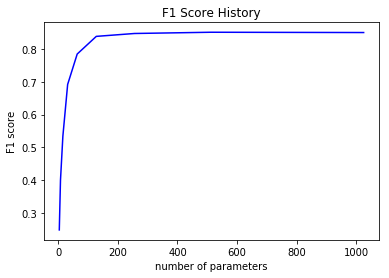

+-----+--------+--------+--------+-------+--------+--------+--------+--------+--------+
|  2  |   4    |   8    |   16   |   32  |   64   |  128   |  256   |  512   |  1024  |
+-----+--------+--------+--------+-------+--------+--------+--------+--------+--------+
| nan | 0.2482 | 0.3999 | 0.5342 | 0.692 | 0.7847 | 0.8386 | 0.8474 | 0.8512 | 0.8503 |
+-----+--------+--------+--------+-------+--------+--------+--------+--------+--------+


In [16]:
plt.title("F1 Score History")
plt.plot(num_paras, f1_history, 'b-')
plt.xlabel('number of parameters')
plt.ylabel('F1 score')
plt.show()

t = PrettyTable(num_paras)
t.add_row(f1_history)
print(t)

When number of parameters is small, sometimes we cannot even get valid $F_{1}$ score, because True Positive and False Posive can both be zero.

When have 128 parameters, we almost get one of the best score, after that point $F_{1}$ score still increases but not changes much.